Political Instability Incidents at the Gridcell Level in Kenya, Tanzania, Mauritius,Somalia and Uganda 

## Load core packages
import pandas as pd # Used to structure data
import numpy as np # Used to structure data
import os # Used to specify directories

## Load other necessary packages
import geopandas as gpd # Used to structure geo-data
import shapely # Used to structure geo-data
import plotly.express as px # Used to visualize data
import plotly.io as pio
pio.renderers.default = 'notebook'
import matplotlib.pyplot as plt # Used to visualize data
%matplotlib inline

## IMPORTING/interpolating & create a dataframe from the array

In [2]:
### LOAD DATA

## Create dataframe of gridcells in the world
import xarray as xr
from scipy.interpolate import griddata

# First create a grid around the world
xi=np.arange(-180,180,.1)
yi=np.arange(-90,90,.1)
xi = np.round(xi,1)
yi = np.round(yi,1)
xi_m,yi_m=np.meshgrid(xi,yi)
nlon = 3600
nlat = 1800

#reading in human population files
#specify path to data file
datadir = '/Users/defaultuser100000/Downloads/fragility-20241218T192434Z-001/fragility/pop_data'

nc_file_humanpop = os.path.join(datadir,'gpw_v4_population_count_adjusted_rev11_30_min.nc')

human_pop_data = xr.open_dataset(nc_file_humanpop)
pop_count = human_pop_data.variables['UN WPP-Adjusted Population Count, v4.11 (2000, 2005, 2010, 2015, 2020): 30 arc-minutes'].values[:]
pop_count_2020 = pop_count[4,:,:]

lon_pop = human_pop_data.variables['longitude'].values[:]
lat_pop = human_pop_data.variables['latitude'].values[:]
lonp_m,latp_m=np.meshgrid(lon_pop,lat_pop)

# interpolating population data to half degree resolution
pop_interpolated_data = griddata((lonp_m.ravel(),latp_m.ravel()),pop_count_2020.ravel(),(xi_m.ravel(),yi_m.ravel()),method='nearest')
pop = pop_interpolated_data.reshape(nlat,nlon)

# create a dataframe from the array
df_pop = pd.DataFrame({'lat': yi_m.ravel(), 'long': xi_m.ravel(), 'population': pop.ravel()})

# If population is less than 150 people per pixel (the unit of the raw data), we set it to 150
df_pop['population'] = np.where(df_pop['population']<150,150,df_pop['population'])
#df_pop

# Convert df_pop to a Geopandas df
df_pop = gpd.GeoDataFrame(
    df_pop
    ,geometry=gpd.points_from_xy(df_pop.long, df_pop.lat)
    ,crs="epsg:4326" # Kind of arbitrarily picking this projection, we could switch it
)

df_pop

,lat,long,population,geometry
0,-90.0,-180.0,NaN,POINT (-180 -90)
1,-90.0,-179.9,NaN,POINT (-179.9 -90)
2,-90.0,-179.8,NaN,POINT (-179.8 -90)
3,-90.0,-179.7,NaN,POINT (-179.7 -90)
4,-90.0,-179.6,NaN,POINT (-179.6 -90)
...,...,...,...,...
6479995,89.9,179.5,NaN,POINT (179.5 89.9)
6479996,89.9,179.6,NaN,POINT (179.6 89.9)
6479997,89.9,179.7,NaN,POINT (179.7 89.9)
6479998,89.9,179.8,NaN,POINT (179.8 89.9)


In [3]:
## Load all incidents - without grouping yet!!

# Get the data
df_incidents = pd.read_csv('C:\\Users\\defaultuser100000\\Downloads\\fragility-20241218T192434Z-001\\2014-01-01-2024-12-31-Eastern_Africa.csv')
 
# Clean data
df_incidents.columns = df_incidents.columns.str.lower()

# Round all events to nearest 0.1 lat/long
df_incidents.latitude = df_incidents.latitude.astype(float)
df_incidents['lat'] = df_incidents.latitude.round(1)
df_incidents.longitude = df_incidents.longitude.astype(float)
df_incidents['long'] = df_incidents.longitude.round(1)
#show data

df_incidents

,event_id_cnty,event_date,year,time_precision,disorder_type,event_type,sub_event_type,actor1,assoc_actor_1,inter1,...,longitude,geo_precision,source,source_scale,notes,fatalities,tags,timestamp,lat,long
0,KEN16601,13 December 2024,2024,1,Demonstrations,Protests,Peaceful protest,Protesters (Kenya),NaN,Protesters,...,34.8333,1,K24; Kenya Broadcasting Corporation; Star (Kenya),National,"On 13 December 2024, residents protested in Ny...",0,crowd size=no report,1734465869,-0.8,34.8
1,KEN16602,13 December 2024,2024,2,Demonstrations,Protests,Peaceful protest,Protesters (Kenya),Labor Group (Kenya); Teachers (Kenya),Protesters,...,35.1167,1,Daily Nation (Kenya),National,"Around 13 December 2024 (as reported), P1 grad...",0,crowd size=no report,1734465870,1.2,35.1
2,MZM4647,13 December 2024,2024,1,Demonstrations,Riots,Violent demonstration,Rioters (Mozambique),NaN,Rioters,...,39.3357,1,Noticias,National,"On 13 December 2024, a group of people gathere...",0,crowd size=no report,1734465913,-15.7,39.3
3,UGA9321,13 December 2024,2024,2,Political violence,Violence against civilians,Attack,Private Security Forces (Uganda),NaN,External/Other forces,...,31.7502,2,Nile Post,National,"Around 13 December 2024, private security atta...",0,NaN,1734466548,0.2,31.8
4,UGA9322,13 December 2024,2024,2,Political violence,Riots,Mob violence,Rioters (Uganda),Vigilante Group (Uganda),Rioters,...,33.5319,1,Nile Post,National,"Around 13 December 2024 (as reported), a group...",1,crowd size=no report,1734466548,0.2,33.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83951,SOM13633,01 January 2014,2014,1,Demonstrations,Protests,Peaceful protest,Protesters (Somalia),NaN,Protesters,...,45.0636,1,Undisclosed Source,Local partner-Other,A group marches in protest of an unknown issue...,0,NaN,1693414520,9.4,45.1
83952,SOM13639,01 January 2014,2014,1,Political violence,Battles,Armed clash,Police Forces of Somalia (2012-2017),NaN,State forces,...,45.3026,1,Undisclosed Source,Local partner-Other,Unidentified attackers hurled a hand grenade a...,0,NaN,1714437994,2.0,45.3
83953,SOM13643,01 January 2014,2014,1,Political violence,Explosions/Remote violence,Grenade,Unidentified Armed Group (Somalia),NaN,Political militia,...,45.3026,1,Undisclosed Source,Local partner-Other,Unidentified attackers hurled a hand grenade a...,0,NaN,1714437994,2.0,45.3
83954,SSD691,01 January 2014,2014,2,Political violence,Violence against civilians,Attack,Military Forces of South Sudan (2011-),NaN,State forces,...,31.5586,1,Irish Independent,International,"Reports of extra judicial killings in Malakal,...",10,NaN,1728421517,6.2,31.6


In [4]:
## Group by grid cell

df_incidents_grouped = df_incidents.groupby(['lat','long']).agg(
    instability_count=('event_id_cnty',"count")
    ,fatalities=('fatalities',"sum")
    ).reset_index()

df_incidents_grouped.sort_values(by="instability_count",ascending=False)

,lat,long,instability_count,fatalities
3445,2.0,45.3,2970,4631
3475,2.1,45.4,1649,1118
3474,2.1,45.3,1213,1118
1680,-3.4,29.4,1207,696
3501,2.2,45.1,999,1237
...,...,...,...,...
4003,3.6,42.7,1,0
5322,8.3,31.4,1,3
2728,0.2,33.8,1,1
5324,8.3,31.8,1,2


In [10]:
## Merge datasets together
df_grid_cell_incidents = pd.merge(df_pop,df_incidents_grouped,on = ['lat','long'],how='left')
# Assign zeros where instability_count and fatalities are missing ### DON'T DO OR IT TURNS MAP GREEN

df_grid_cell_incidents[df_grid_cell_incidents['instability_count'].notnull()]

,lat,long,population,geometry,instability_count,fatalities,instability_count_trimmed
2277329,-26.8,32.9,54998.308594,POINT (32.9 -26.8),3.0,2.0,3.0
2306120,-26.0,32.0,152191.093750,POINT (32 -26),2.0,0.0,2.0
2306123,-26.0,32.3,140735.640625,POINT (32.3 -26),21.0,1.0,21.0
2306125,-26.0,32.5,140735.640625,POINT (32.5 -26),62.0,32.0,62.0
2306126,-26.0,32.6,35916.578125,POINT (32.6 -26),219.0,75.0,168.4
...,...,...,...,...,...,...,...
3792989,15.3,38.9,923216.750000,POINT (38.9 15.3),15.0,23.0,15.0
3800175,15.5,37.5,113713.593750,POINT (37.5 15.5),1.0,0.0,1.0
3803794,15.6,39.4,115151.195312,POINT (39.4 15.6),1.0,6.0,1.0
3803801,15.6,40.1,4873.422363,POINT (40.1 15.6),1.0,1.0,1.0


In [11]:
# Check to see if we have any gridcells with incidents but no pop data

df_prob = df_grid_cell_incidents[(df_grid_cell_incidents['instability_count'].notnull()) & (df_grid_cell_incidents['population'].isnull())].copy()

df_prob.sort_values(by='instability_count',ascending=False)

# Thankfully we don't have any missing pop data

,lat,long,population,geometry,instability_count,fatalities,instability_count_trimmed
3656447,11.5,64.7,NaN,POINT (64.7 11.5),5.0,0.0,5.0
3674308,12.0,50.8,NaN,POINT (50.8 12),4.0,11.0,4.0
3404280,4.5,48.0,NaN,POINT (48 4.5),3.0,0.0,3.0
3660022,11.6,62.2,NaN,POINT (62.2 11.6),3.0,0.0,3.0
3692279,12.5,47.9,NaN,POINT (47.9 12.5),1.0,0.0,1.0


In [12]:
## Calculate instability_count_per_capita

# Divide incidents by population
df_grid_cell_incidents['instability_count_per_1000'] = (df_grid_cell_incidents['instability_count'] / df_grid_cell_incidents['population'] * 1000)

# Do a trimmed version
df_grid_cell_incidents['instability_count_per_1000_trimmed'] = df_grid_cell_incidents['instability_count_per_1000'].clip(upper=df_grid_cell_incidents['instability_count_per_1000'].quantile(0.99))

df_grid_cell_incidents.sort_values(by='instability_count_per_1000',ascending=False)

,lat,long,population,geometry,instability_count,fatalities,instability_count_trimmed,instability_count_per_1000,instability_count_per_1000_trimmed
3656299,11.5,49.9,150.000000,POINT (49.9 11.5),49.0,118.0,49.0,326.666667,2.241214
2590640,-18.1,44.0,150.000000,POINT (44 -18.1),22.0,22.0,22.0,146.666667,2.241214
3314253,2.0,45.3,32790.027344,POINT (45.3 2),2970.0,4631.0,168.4,90.576320,2.241214
3184616,-1.6,41.6,1375.925537,POINT (41.6 -1.6),43.0,103.0,43.0,31.251691,2.241214
2774251,-13.0,45.1,150.000000,POINT (45.1 -13),4.0,0.0,4.0,26.666667,2.241214
...,...,...,...,...,...,...,...,...,...
6479995,89.9,179.5,NaN,POINT (179.5 89.9),NaN,NaN,NaN,NaN,NaN
6479996,89.9,179.6,NaN,POINT (179.6 89.9),NaN,NaN,NaN,NaN,NaN
6479997,89.9,179.7,NaN,POINT (179.7 89.9),NaN,NaN,NaN,NaN,NaN
6479998,89.9,179.8,NaN,POINT (179.8 89.9),NaN,NaN,NaN,NaN,NaN


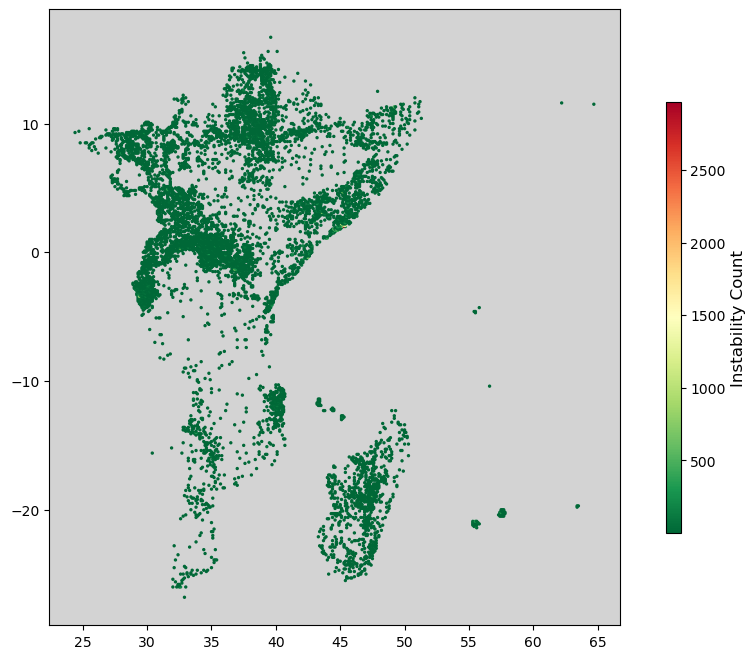

In [15]:
## Plot east african country 

df_world = gpd.GeoDataFrame(
    df_grid_cell_incidents
    ,geometry=df_grid_cell_incidents.geometry
    ,crs="epsg:4326" # Kind of arbitrarily picking this projection, we could switch it
)

ax = df_world.plot(markersize=2, figsize=(12, 8),
            column='instability_count'
              ,cmap='RdYlGn_r'
            ,legend=True
            ,legend_kwds={'shrink': 0.7, 'aspect': 30}  # Adjust the size of the color bar
             )
#plt.autoscale(False)

ax.set_facecolor('lightgray')         # Set a light gray background just for the plotting area
# Customize the color bar
cbar = ax.get_figure().get_axes()[-1]  # Get the color bar axis
cbar.set_ylabel('Instability Count', fontsize=12)
# Add ADM-1 outlines
# Filter for the country of interest by ISO 2-letter country code
## Set some figure-wide settings
title = 'Political Instability Incidents at the Gridcell Level across the World (2014-2024)'
plt.show()

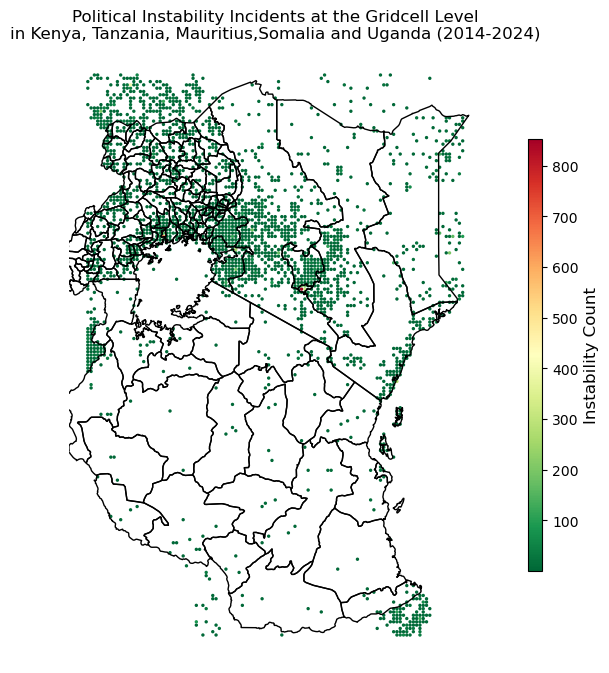

In [18]:
## Plot grid-cells using a bounding box
# East Africa

# Turn dataframe into a GeoPandas dataframe
df_ky_tz = gpd.GeoDataFrame(
    df_grid_cell_incidents
    ,geometry=df_grid_cell_incidents.geometry
    ,crs="epsg:4326" # Kind of arbitrarily picking this projection, we could switch it
)

# Set box boundaries
xmin = 30.27 # Westernmost point
xmax = 41.79 # Eastermost point
ymin = -11.86 # Southernmost point
ymax = 5.26 # Northernmost point

box = df_ky_tz.cx[xmin:xmax, ymin:ymax]

ax = box.plot(markersize=2, figsize=(12, 8),
            column='instability_count'
              ,cmap='RdYlGn_r'
            ,legend=True
            ,legend_kwds={'shrink': 0.7, 'aspect': 30}  # Adjust the size of the color bar
             )
plt.autoscale(False)

ax.set_facecolor('lightgray')         # Set a light gray background just for the plotting area

# Customize the color bar
cbar = ax.get_figure().get_axes()[-1]  # Get the color bar axis
cbar.set_ylabel('Instability Count', fontsize=12)

# Add ADM-1 outlines
adm1s = gpd.read_file('C:\\Users\\defaultuser100000\\Downloads\\fragility-20241218T192434Z-001\\fragility\\natural_earth_geo_files\\ne_10m_admin_1\\ne_10m_admin_1_states_provinces_lakes.shp')

# Filter for the country of interest by ISO 2-letter country code
adm1s = adm1s[adm1s['iso_a2'].isin(['TZ', 'KE','UG','MZM','SOM'])]
adm1s.to_crs(df_grid_cell_incidents.crs).plot(ax=ax, color='none', edgecolor='black')

## Set some figure-wide settings
title = 'Political Instability Incidents at the Gridcell Level\nin Kenya, Tanzania, Mauritius,Somalia and Uganda (2014-2024)'
plt.title(title)
ax.axis('off')

plt.show()

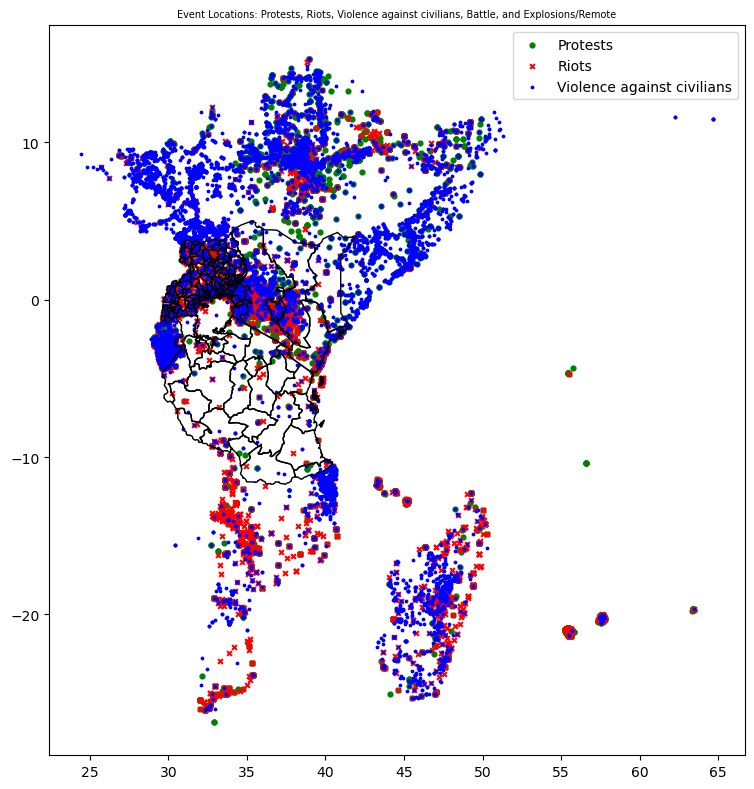

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Creating GeoDataFrame
df_ky_tz = gpd.GeoDataFrame(
    df_incidents,
    geometry=gpd.points_from_xy(df_incidents.longitude, df_incidents.latitude),
    crs="epsg:4326"
)

# Set up the plotting area
fig, ax = plt.subplots(figsize=(12, 8))

# Define event types and their properties
event_types = {
    'Protests': {'color': 'green', 'marker': 'o'},
    'Riots': {'color': 'red', 'marker': 'x'},
    'Violence against civilians': {'color': 'blue', 'marker': '.'},
    'Explosions/Remote': {'color': 'purple', 'marker': 'p'},
    'Battle': {'color': 'yellow', 'marker': '*'}
}

# Plot each event type
for event_type, props in event_types.items():
    events = df_ky_tz[df_ky_tz['event_type'] == event_type]
    if not events.empty:
        events.plot(
            ax=ax,
            markersize=12,
            color=props['color'],
            marker=props['marker'],
            label=event_type
        )

# Load and plot administrative boundaries
adm1s = gpd.read_file('C:\\Users\\defaultuser100000\\Downloads\\fragility-20241218T192434Z-001\\fragility\\natural_earth_geo_files\\ne_10m_admin_1\\ne_10m_admin_1_states_provinces_lakes.shp')
adm1s = adm1s[adm1s['iso_a2'].isin(['TZ', 'KE', 'UG'])]
adm1s.to_crs(df_ky_tz.crs).plot(ax=ax, color='none', edgecolor='black')

# Set titles and labels
ax.set_title('Event Locations: Protests, Riots, Violence against civilians, Battle, and Explosions/Remote', fontsize=7)

# Show the plot
plt.tight_layout()  # Ensure layout is clean
plt.show()

